In [5]:
# ========================================
# PROJET DEEP LEARNING - DÉTECTION DU PALUDISME
# Master 1 DSGL - UADB
# ========================================

In [6]:
# ========================================
# 1. IMPORTATION DES PACKAGES
# ========================================

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import cv2
import os
import random
from PIL import Image

# Keras/TensorFlow
from tensorflow.keras.utils import load_img, img_to_array, to_categorical
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.models import Sequential, load_model
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Dropout, Flatten, Dense, BatchNormalization, Activation
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint, ReduceLROnPlateau
from tensorflow.keras.optimizers import Adam

# Sklearn
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, classification_report, accuracy_score

# Warnings
import warnings
warnings.filterwarnings('ignore')

print("✅ Packages importés avec succès!")

✅ Packages importés avec succès!


In [7]:
# ========================================
# 2. CHARGEMENT DES DONNÉES
# ========================================

# Définir les chemins
DATA_DIR = 'cell_images'
PARASITIZED_DIR = os.path.join(DATA_DIR, 'Parasitized')
UNINFECTED_DIR = os.path.join(DATA_DIR, 'Uninfected')

# Paramètres
IMG_SIZE = 64  # Taille des images (64x64 pixels)
BATCH_SIZE = 32
EPOCHS = 30

print(f"📂 Chargement des données depuis : {DATA_DIR}")

# Fonction pour charger les images
def load_images_from_folder(folder, label, img_size=IMG_SIZE):
    """
    Charge les images depuis un dossier et les redimensionne
    """
    images = []
    labels = []
    
    files = os.listdir(folder)
    print(f"   - Chargement de {len(files)} images de la classe {label}...")
    
    for filename in files:
        img_path = os.path.join(folder, filename)
        try:
            img = cv2.imread(img_path)
            if img is not None:
                img = cv2.resize(img, (img_size, img_size))
                img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
                images.append(img)
                labels.append(label)
        except Exception as e:
            print(f"Erreur lors du chargement de {filename}: {e}")
    
    return images, labels

# Charger les images parasitées (label = 1)
parasitized_images, parasitized_labels = load_images_from_folder(PARASITIZED_DIR, 1)

# Charger les images non infectées (label = 0)
uninfected_images, uninfected_labels = load_images_from_folder(UNINFECTED_DIR, 0)

# Combiner les données
X = np.array(parasitized_images + uninfected_images)
y = np.array(parasitized_labels + uninfected_labels)

print(f"\n✅ Données chargées:")
print(f"   - Forme des images: {X.shape}")
print(f"   - Nombre total d'images: {len(X)}")
print(f"   - Cellules parasitées: {len(parasitized_images)}")
print(f"   - Cellules non infectées: {len(uninfected_images)}")

📂 Chargement des données depuis : cell_images
   - Chargement de 13780 images de la classe 1...


   - Chargement de 13780 images de la classe 0...

✅ Données chargées:
   - Forme des images: (27558, 64, 64, 3)
   - Nombre total d'images: 27558
   - Cellules parasitées: 13779
   - Cellules non infectées: 13779



📊 Visualisation des échantillons:


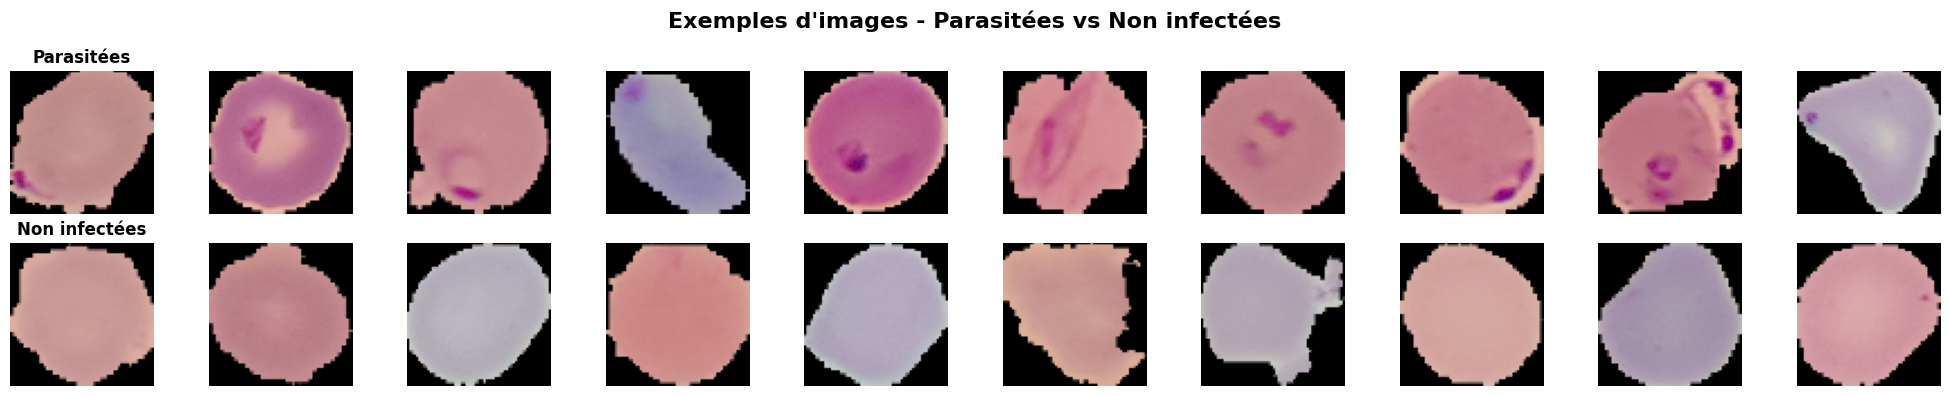

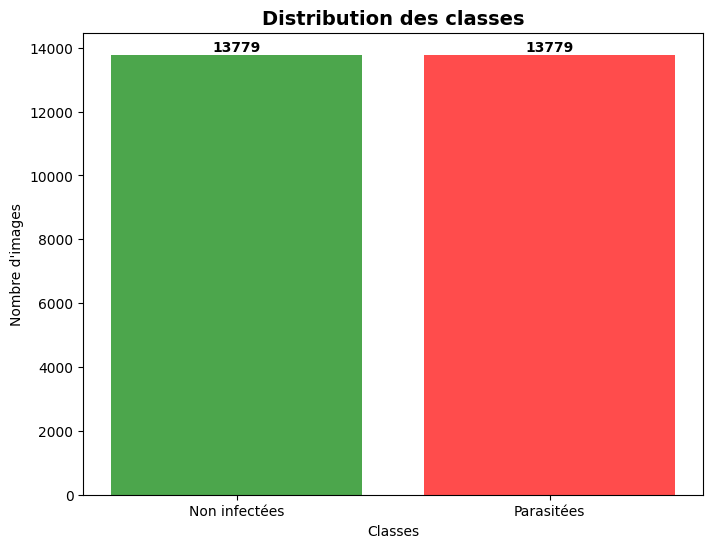

In [8]:
# ========================================
# 3. VISUALISATION DES DONNÉES
# ========================================

def plot_sample_images(X, y, n_samples=10):
    """
    Affiche des exemples d'images des deux classes
    """
    fig, axes = plt.subplots(2, n_samples, figsize=(20, 4))
    fig.suptitle('Exemples d\'images - Parasitées vs Non infectées', fontsize=16, fontweight='bold')
    
    # Images parasitées
    parasitized_indices = np.where(y == 1)[0]
    for i in range(n_samples):
        idx = random.choice(parasitized_indices)
        axes[0, i].imshow(X[idx])
        axes[0, i].axis('off')
        if i == 0:
            axes[0, i].set_title('Parasitées', fontweight='bold')
    
    # Images non infectées
    uninfected_indices = np.where(y == 0)[0]
    for i in range(n_samples):
        idx = random.choice(uninfected_indices)
        axes[1, i].imshow(X[idx])
        axes[1, i].axis('off')
        if i == 0:
            axes[1, i].set_title('Non infectées', fontweight='bold')
    
    plt.tight_layout()
    plt.show()

print("\n📊 Visualisation des échantillons:")
plot_sample_images(X, y, n_samples=10)

# Distribution des classes
plt.figure(figsize=(8, 6))
unique, counts = np.unique(y, return_counts=True)
plt.bar(['Non infectées', 'Parasitées'], counts, color=['green', 'red'], alpha=0.7)
plt.title('Distribution des classes', fontsize=14, fontweight='bold')
plt.ylabel('Nombre d\'images')
plt.xlabel('Classes')
for i, count in enumerate(counts):
    plt.text(i, count + 100, str(count), ha='center', fontweight='bold')
plt.show()

In [9]:
# ========================================
# 4. NORMALISATION DES DONNÉES
# ========================================

# Normaliser les valeurs des pixels entre 0 et 1
X = X.astype('float32') / 255.0

print(f"\n✅ Normalisation effectuée")
print(f"   - Min: {X.min()}, Max: {X.max()}")


✅ Normalisation effectuée
   - Min: 0.0, Max: 1.0


In [10]:
# 5. DIVISION DES DONNÉES
# ========================================

# Mélanger les données
indices = np.arange(len(X))
np.random.shuffle(indices)
X = X[indices]
y = y[indices]

# Split 1: Train (70%) + Temp (30%)
X_train, X_temp, y_train, y_temp = train_test_split(
    X, y, test_size=0.3, random_state=42, stratify=y
)

# Split 2: Validation (15%) + Test (15%)
X_val, X_test, y_val, y_test = train_test_split(
    X_temp, y_temp, test_size=0.5, random_state=42, stratify=y_temp
)

print(f"\n✅ Division des données:")
print(f"   - Train: {X_train.shape[0]} images ({X_train.shape[0]/len(X)*100:.1f}%)")
print(f"   - Validation: {X_val.shape[0]} images ({X_val.shape[0]/len(X)*100:.1f}%)")
print(f"   - Test: {X_test.shape[0]} images ({X_test.shape[0]/len(X)*100:.1f}%)")



✅ Division des données:
   - Train: 19290 images (70.0%)
   - Validation: 4134 images (15.0%)
   - Test: 4134 images (15.0%)


In [11]:
# ========================================
# 6. DATA AUGMENTATION
# ========================================

datagen = ImageDataGenerator(
    rotation_range=20,
    width_shift_range=0.2,
    height_shift_range=0.2,
    horizontal_flip=True,
    vertical_flip=True,
    zoom_range=0.2,
    shear_range=0.15,
    fill_mode='nearest'
)

datagen.fit(X_train)

print("\n✅ Data Augmentation configuré")



✅ Data Augmentation configuré


In [12]:
# ========================================
# 7. CRÉATION DES MODÈLES CNN
# ========================================

def create_model_1():
    """
    Modèle 1: CNN Simple (Baseline)
    """
    model = Sequential([
        Conv2D(32, (3, 3), activation='relu', input_shape=(IMG_SIZE, IMG_SIZE, 3)),
        MaxPooling2D(2, 2),
        
        Conv2D(64, (3, 3), activation='relu'),
        MaxPooling2D(2, 2),
        
        Flatten(),
        Dense(128, activation='relu'),
        Dropout(0.5),
        Dense(1, activation='sigmoid')
    ], name='Model_1_Simple')
    
    return model

def create_model_2():
    """
    Modèle 2: CNN avec BatchNormalization et Dropout
    """
    model = Sequential([
        Conv2D(32, (3, 3), padding='same', input_shape=(IMG_SIZE, IMG_SIZE, 3)),
        BatchNormalization(),
        Activation('relu'),
        MaxPooling2D(2, 2),
        Dropout(0.25),
        
        Conv2D(64, (3, 3), padding='same'),
        BatchNormalization(),
        Activation('relu'),
        MaxPooling2D(2, 2),
        Dropout(0.25),
        
        Conv2D(128, (3, 3), padding='same'),
        BatchNormalization(),
        Activation('relu'),
        MaxPooling2D(2, 2),
        Dropout(0.25),
        
        Flatten(),
        Dense(256, activation='relu'),
        BatchNormalization(),
        Dropout(0.5),
        Dense(1, activation='sigmoid')
    ], name='Model_2_BatchNorm')
    
    return model

def create_model_3():
    """
    Modèle 3: CNN Profond (Type VGG simplifié)
    """
    model = Sequential([
        # Block 1
        Conv2D(64, (3, 3), activation='relu', padding='same', input_shape=(IMG_SIZE, IMG_SIZE, 3)),
        Conv2D(64, (3, 3), activation='relu', padding='same'),
        MaxPooling2D(2, 2),
        Dropout(0.25),
        
        # Block 2
        Conv2D(128, (3, 3), activation='relu', padding='same'),
        Conv2D(128, (3, 3), activation='relu', padding='same'),
        MaxPooling2D(2, 2),
        Dropout(0.25),
        
        # Block 3
        Conv2D(256, (3, 3), activation='relu', padding='same'),
        Conv2D(256, (3, 3), activation='relu', padding='same'),
        MaxPooling2D(2, 2),
        Dropout(0.25),
        
        # Classification
        Flatten(),
        Dense(512, activation='relu'),
        BatchNormalization(),
        Dropout(0.5),
        Dense(256, activation='relu'),
        Dropout(0.5),
        Dense(1, activation='sigmoid')
    ], name='Model_3_Deep_VGG')
    
    return model

print("\n✅ Architectures des modèles créées")



✅ Architectures des modèles créées


In [13]:
# ========================================
# 8. ENTRAÎNEMENT DES MODÈLES
# ========================================

def train_model(model, model_name):
    """
    Entraîne un modèle et retourne l'historique
    """
    print(f"\n{'='*60}")
    print(f"🚀 ENTRAÎNEMENT DU {model_name}")
    print(f"{'='*60}")
    
    # Compiler le modèle
    model.compile(
        optimizer=Adam(learning_rate=0.001),
        loss='binary_crossentropy',
        metrics=['accuracy']
    )
    
    # Callbacks
    early_stop = EarlyStopping(
        monitor='val_loss',
        patience=5,
        restore_best_weights=True,
        verbose=1
    )
    
    checkpoint = ModelCheckpoint(
    f'{model_name}.keras',  # Nouveau format
    monitor='val_accuracy',
    save_best_only=True,
    verbose=1
)
    
    reduce_lr = ReduceLROnPlateau(
        monitor='val_loss',
        factor=0.5,
        patience=3,
        min_lr=1e-7,
        verbose=1
    )
    
    # Entraînement
    history = model.fit(
        datagen.flow(X_train, y_train, batch_size=BATCH_SIZE),
        epochs=EPOCHS,
        validation_data=(X_val, y_val),
        callbacks=[early_stop, checkpoint, reduce_lr],
        verbose=1
    )
    
    print(f"\n✅ {model_name} entraîné avec succès!")
    
    return history

# Créer et entraîner les modèles
models_dict = {}
histories_dict = {}

# Modèle 1
model_1 = create_model_1()
print(f"\n📋 Architecture du Modèle 1:")
model_1.summary()
history_1 = train_model(model_1, "Model_1_Simple")
models_dict['Model 1 (Simple)'] = model_1
histories_dict['Model 1 (Simple)'] = history_1

# Modèle 2
model_2 = create_model_2()
print(f"\n📋 Architecture du Modèle 2:")
model_2.summary()
history_2 = train_model(model_2, "Model_2_BatchNorm")
models_dict['Model 2 (BatchNorm)'] = model_2
histories_dict['Model 2 (BatchNorm)'] = history_2

# Modèle 3
model_3 = create_model_3()
print(f"\n📋 Architecture du Modèle 3:")
model_3.summary()
history_3 = train_model(model_3, "Model_3_Deep_VGG")
models_dict['Model 3 (Deep VGG)'] = model_3
histories_dict['Model 3 (Deep VGG)'] = history_3



📋 Architecture du Modèle 1:
Model: "Model_1_Simple"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 62, 62, 32)        896       
                                                                 
 max_pooling2d (MaxPooling2  (None, 31, 31, 32)        0         
 D)                                                              
                                                                 
 conv2d_1 (Conv2D)           (None, 29, 29, 64)        18496     
                                                                 
 max_pooling2d_1 (MaxPoolin  (None, 14, 14, 64)        0         
 g2D)                                                            
                                                                 
 flatten (Flatten)           (None, 12544)             0         
                                                                 
 dense (Dense)         


📊 Courbes d'apprentissage:


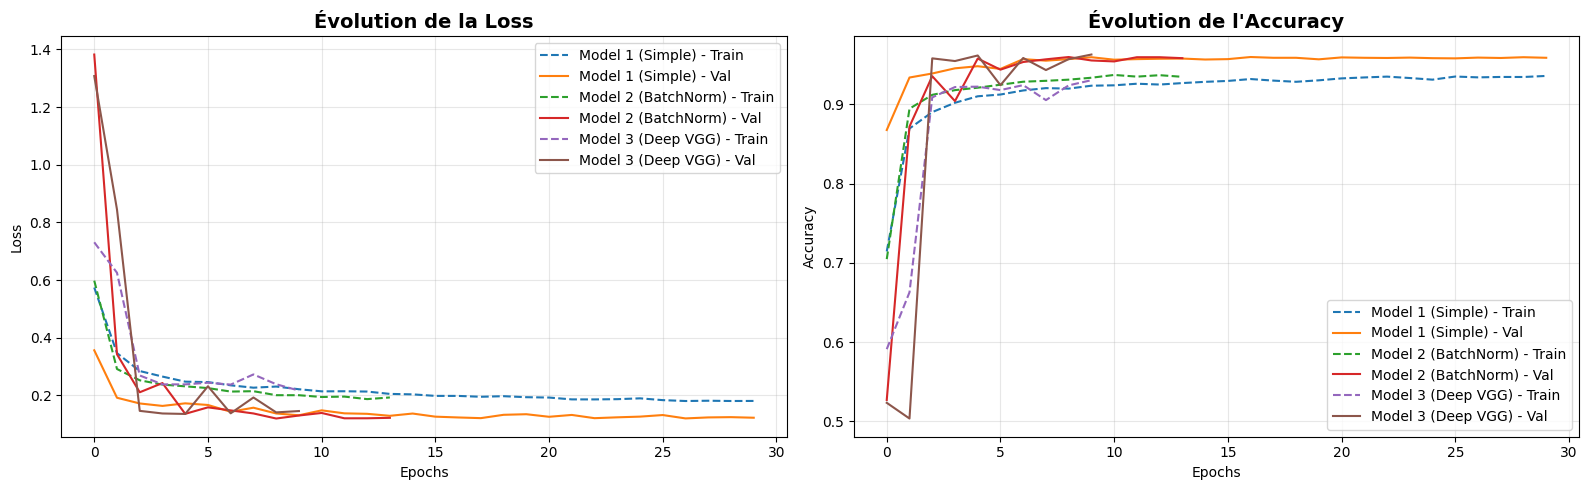


📈 ÉVALUATION DU Model 1 (Simple)
130/130 [==============================] - 4s 27ms/step

✅ Accuracy sur le test set: 95.21%

📊 Rapport de classification:
              precision    recall  f1-score   support

Non infectée       0.93      0.98      0.95      2067
   Parasitée       0.98      0.93      0.95      2067

    accuracy                           0.95      4134
   macro avg       0.95      0.95      0.95      4134
weighted avg       0.95      0.95      0.95      4134



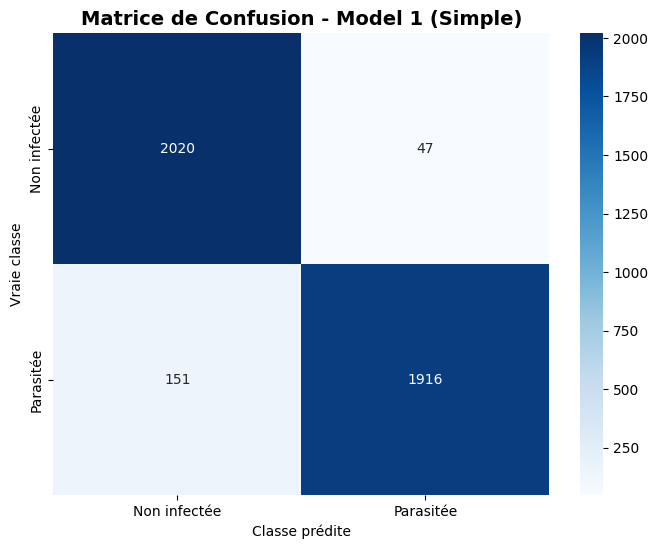


📈 ÉVALUATION DU Model 2 (BatchNorm)
130/130 [==============================] - 9s 71ms/step

✅ Accuracy sur le test set: 95.69%

📊 Rapport de classification:
              precision    recall  f1-score   support

Non infectée       0.94      0.97      0.96      2067
   Parasitée       0.97      0.94      0.96      2067

    accuracy                           0.96      4134
   macro avg       0.96      0.96      0.96      4134
weighted avg       0.96      0.96      0.96      4134



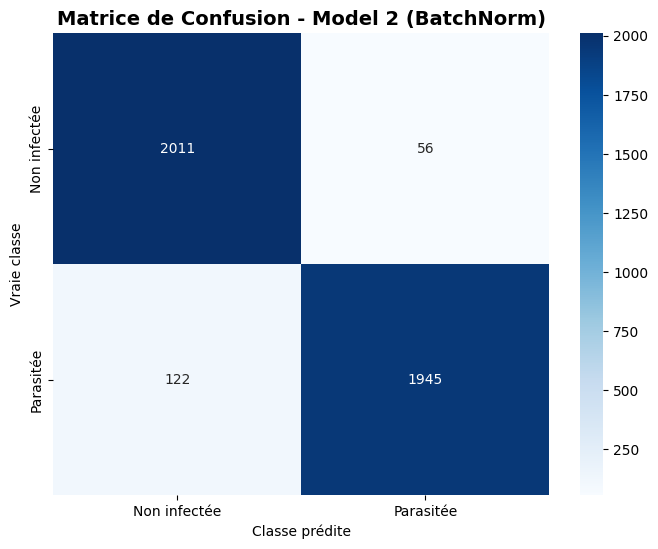


📈 ÉVALUATION DU Model 3 (Deep VGG)
130/130 [==============================] - 42s 320ms/step

✅ Accuracy sur le test set: 95.65%

📊 Rapport de classification:
              precision    recall  f1-score   support

Non infectée       0.94      0.98      0.96      2067
   Parasitée       0.97      0.94      0.96      2067

    accuracy                           0.96      4134
   macro avg       0.96      0.96      0.96      4134
weighted avg       0.96      0.96      0.96      4134



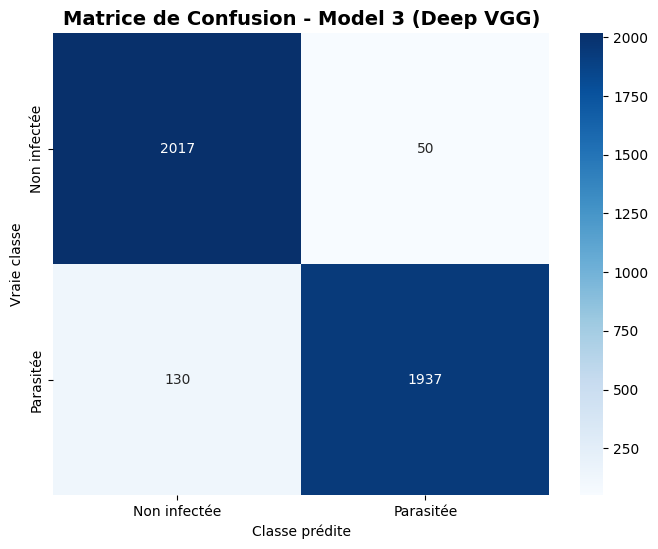

In [14]:
# ========================================
# 9. ÉVALUATION DES MODÈLES
# ========================================

def plot_training_history(histories_dict):
    """
    Affiche les courbes d'apprentissage de tous les modèles
    """
    fig, axes = plt.subplots(1, 2, figsize=(16, 5))
    
    # Loss

    for name, history in histories_dict.items():
        axes[0].plot(history.history['loss'], label=f'{name} - Train', linestyle='--')
        axes[0].plot(history.history['val_loss'], label=f'{name} - Val')
    axes[0].set_title('Évolution de la Loss', fontsize=14, fontweight='bold')
    axes[0].set_xlabel('Epochs')
    axes[0].set_ylabel('Loss')
    axes[0].legend()
    axes[0].grid(True, alpha=0.3)
    
    # Accuracy
    for name, history in histories_dict.items():
        axes[1].plot(history.history['accuracy'], label=f'{name} - Train', linestyle='--')
        axes[1].plot(history.history['val_accuracy'], label=f'{name} - Val')
    axes[1].set_title('Évolution de l\'Accuracy', fontsize=14, fontweight='bold')
    axes[1].set_xlabel('Epochs')
    axes[1].set_ylabel('Accuracy')
    axes[1].legend()
    axes[1].grid(True, alpha=0.3)
    
    plt.tight_layout()
    plt.show()

print("\n📊 Courbes d'apprentissage:")
plot_training_history(histories_dict)

def evaluate_model(model, model_name, X_test, y_test):
    """
    Évalue un modèle sur les données de test
    """
    print(f"\n{'='*60}")
    print(f"📈 ÉVALUATION DU {model_name}")
    print(f"{'='*60}")
    
    # Prédictions
    y_pred_proba = model.predict(X_test)
    y_pred = (y_pred_proba > 0.5).astype(int).flatten()
    
    # Métriques
    accuracy = accuracy_score(y_test, y_pred)
    print(f"\n✅ Accuracy sur le test set: {accuracy*100:.2f}%")
    
    # Rapport de classification
    print("\n📊 Rapport de classification:")
    print(classification_report(y_test, y_pred, target_names=['Non infectée', 'Parasitée']))
    
    # Matrice de confusion
    cm = confusion_matrix(y_test, y_pred)
    plt.figure(figsize=(8, 6))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', 
                xticklabels=['Non infectée', 'Parasitée'],
                yticklabels=['Non infectée', 'Parasitée'])
    plt.title(f'Matrice de Confusion - {model_name}', fontsize=14, fontweight='bold')
    plt.ylabel('Vraie classe')
    plt.xlabel('Classe prédite')
    plt.show()
    
    return accuracy, y_pred

# Évaluer tous les modèles
results = {}
for name, model in models_dict.items():
    accuracy, y_pred = evaluate_model(model, name, X_test, y_test)
    results[name] = accuracy



🏆 COMPARAISON DES MODÈLES

             Modèle  Accuracy (%)  Rang
Model 2 (BatchNorm)     95.694243     1
 Model 3 (Deep VGG)     95.645864     2
   Model 1 (Simple)     95.210450     3


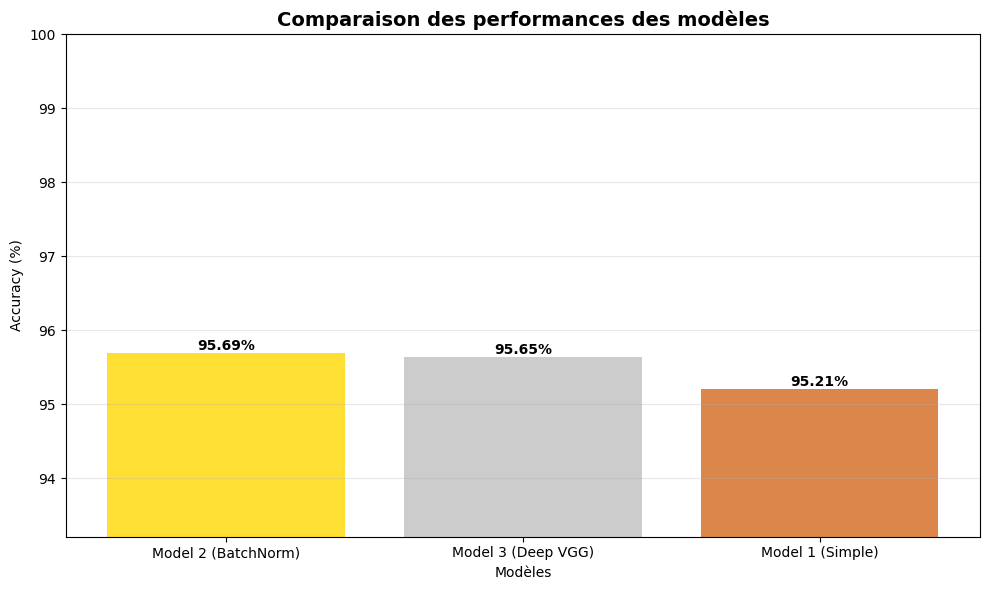

In [15]:
# ========================================
# 10. COMPARAISON DES MODÈLES
# ========================================

print(f"\n{'='*60}")
print("🏆 COMPARAISON DES MODÈLES")
print(f"{'='*60}\n")

# Tableau de comparaison
comparison_df = pd.DataFrame({
    'Modèle': list(results.keys()),
    'Accuracy (%)': [acc*100 for acc in results.values()]
})
comparison_df = comparison_df.sort_values('Accuracy (%)', ascending=False).reset_index(drop=True)
comparison_df['Rang'] = range(1, len(comparison_df) + 1)

print(comparison_df.to_string(index=False))

# Graphique de comparaison
plt.figure(figsize=(10, 6))
bars = plt.bar(comparison_df['Modèle'], comparison_df['Accuracy (%)'], 
               color=['gold', 'silver', 'chocolate'], alpha=0.8)
plt.title('Comparaison des performances des modèles', fontsize=14, fontweight='bold')
plt.ylabel('Accuracy (%)')
plt.xlabel('Modèles')
plt.ylim([min(comparison_df['Accuracy (%)']) - 2, 100])
plt.grid(axis='y', alpha=0.3)

# Ajouter les valeurs sur les barres
for bar in bars:
    height = bar.get_height()
    plt.text(bar.get_x() + bar.get_width()/2., height,
             f'{height:.2f}%', ha='center', va='bottom', fontweight='bold')

plt.tight_layout()
plt.show()

In [16]:
# ========================================
# 11. SAUVEGARDE DU MEILLEUR MODÈLE
# ========================================

best_model_name = comparison_df.iloc[0]['Modèle']
best_model = models_dict[best_model_name]
best_accuracy = comparison_df.iloc[0]['Accuracy (%)']

# Sauvegarder le meilleur modèle
best_model.save('best_malaria_model.keras')  # Au lieu de .h5
print(f"\n✅ Meilleur modèle sauvegardé: {best_model_name}")
print(f"   Accuracy: {best_accuracy:.2f}%")
print(f"   Fichier: best_malaria_model.keras")



✅ Meilleur modèle sauvegardé: Model 2 (BatchNorm)
   Accuracy: 95.69%
   Fichier: best_malaria_model.keras



🔮 Test de prédiction avec le meilleur modèle:


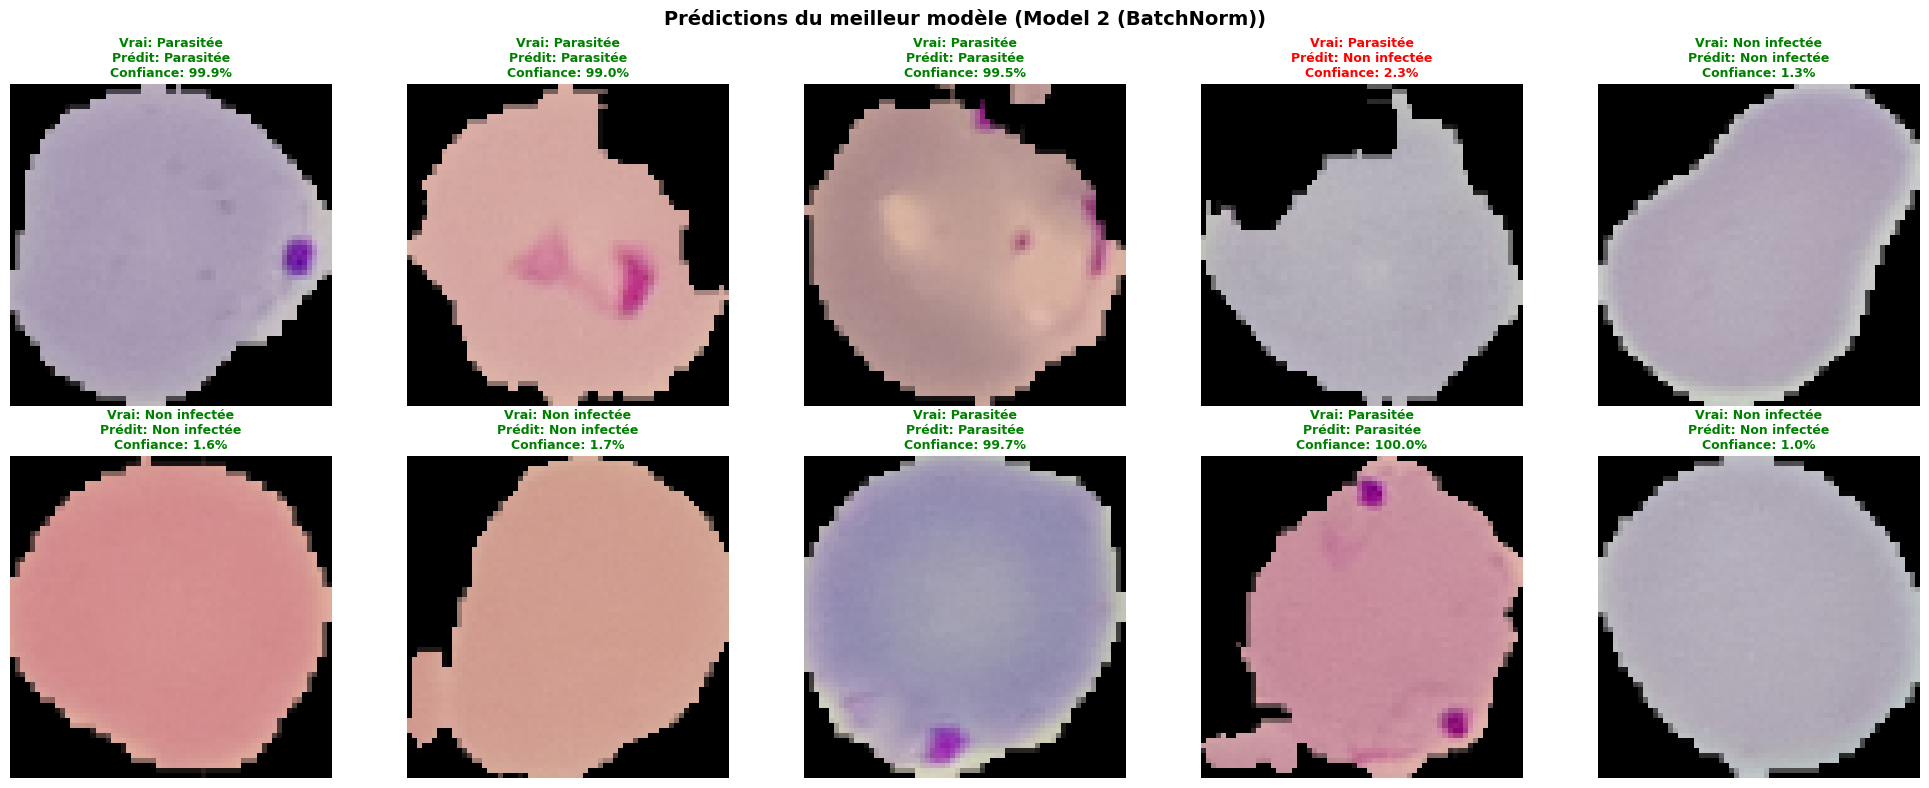


✅ PROJET TERMINÉ AVEC SUCCÈS!

📝 Prochaines étapes:
   1. Déploiement avec Flask
   2. Création de l'interface web
   3. Rédaction du rapport


In [ ]:
# ========================================
# 12. TEST DE PRÉDICTION
# ========================================

def predict_sample_images(model, X_test, y_test, n_samples=10):
    """
    Affiche des prédictions sur des échantillons aléatoires
    """
    indices = random.sample(range(len(X_test)), n_samples)
    
    fig, axes = plt.subplots(2, n_samples//2, figsize=(20, 8))
    axes = axes.ravel()
    
    for i, idx in enumerate(indices):
        img = X_test[idx]
        true_label = y_test[idx]
        
        # Prédiction
        pred_proba = model.predict(img.reshape(1, IMG_SIZE, IMG_SIZE, 3), verbose=0)[0][0]
        pred_label = 1 if pred_proba > 0.5 else 0
        
        # Affichage
        axes[i].imshow(img)
        axes[i].axis('off')
        
        color = 'green' if pred_label == true_label else 'red'
        true_class = 'Parasitée' if true_label == 1 else 'Non infectée'
        pred_class = 'Parasitée' if pred_label == 1 else 'Non infectée'
        
        axes[i].set_title(f'Vrai: {true_class}\nPrédit: {pred_class}\nConfiance: {pred_proba*100:.1f}%',
                         color=color, fontweight='bold', fontsize=9)
    
    plt.suptitle(f'Prédictions du meilleur modèle ({best_model_name})', 
                 fontsize=14, fontweight='bold')
    plt.tight_layout()
    plt.show()

print(f"\n🔮 Test de prédiction avec le meilleur modèle:")
predict_sample_images(best_model, X_test, y_test, n_samples=10)

print(f"\n{'='*60}")
print("✅ PROJET TERMINÉ AVEC SUCCÈS!")
print(f"{'='*60}")